In [1]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
from soilgasflux_fcs import pareto
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

In [52]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')

test_number = 6
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
print(filename_regular)
print(filename_mc)
print(filename_expected)

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test06_noNorm_test5_2025-05-08.nc
test06_MC_noNorm_test5_2025-05-08.nc
expected_test06_2025-05-08.nc


In [53]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [54]:
cm = 1/2.54

## Ridge plot


for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values
        
        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                # fig, ax = plt.subplots(2, 3, figsize=(8, 4))
                
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                uncertaintyRange_hm = (dsMC.sel(time=time_selection).quantile(0.84, dim=['MC'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC'])['dcdt(HM)'])#/mc_hm
                logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC'])['logprob(HM)']
                logprob_hm = logprob_hm.where(logprob_hm != np.inf, np.nan)  # Replace inf with NaN for better handling

                Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
                
                flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

                # Find Pareto front
                pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                                    y=flatNorm_logprob, 
                                                                    maximize_x=False, maximize_y=False)
                coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
                
                distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                                (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
                argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
                
                best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
                best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]
                # print(deadband_coords[best_pareto_y].values,cutoff_coords[best_pareto_x].values)
                hist_dcdt = dsMC.sel(time=time_selection,
                                    cutoff=cutoff_coords[best_pareto_x].values, 
                                    deadband=deadband_coords[best_pareto_y].values)['dcdt(HM)']
                # print(hist_dcdt)
                hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)


                arbitrary_results = {'deadband':[10,30, 30,50,50],
                                     'cutoff':[70,120,170,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
                # print(ds)
                for deadband, cutoff in zip(arbitrary_results['deadband'], arbitrary_results['cutoff']):
                    dcdt_arb = ds.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)
                    arbitrary_results['dcdt(HM)'].append(dcdt_arb['dcdt(HM)'].values)
                    arbitrary_results['R2'].append(dcdt_arb['R2(HM)'].values)

                # print(arbitrary_results)

                                
                hist_dcdt_pareto = dsMC.sel(time=time_selection,
                                            cutoff=cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]], 
                                            deadband=deadband_coords[coords_pareto_uncertaintyRange_logprob[1]])['dcdt(HM)']
                
                df_pareto = pd.DataFrame()
                for deadband, cutoff in zip(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values, 
                                                                cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values):
                    hist_dcdt = dsMC.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)['dcdt(HM)']
                    hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                    hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)
                    df_pareto = pd.concat([df_pareto, hist_dcdt.to_dataframe().reset_index()], ignore_index=True)
                
                df_pareto['deadband-cutoff'] = df_pareto['deadband'].astype(str) + ' - ' + df_pareto['cutoff'].astype(str)
                # print(df_pareto)

                # pal = sns.cubehelix_palette(len(np.unique(df_pareto['deadband-cutoff'])), start=-0.25, light=.7)
                colors = ['#d98088' for _ in range(len(np.unique(df_pareto['deadband-cutoff'])))]
                colors = []
                for c in range(len(np.unique(df_pareto['deadband-cutoff']))):
                    if c == argmin_distance_pareto_uncertaintyRange_logprob:
                        colors.append('#1f77b4')
                    else:
                        colors.append('#d98088')

                pal = sns.color_palette(colors)


                g = sns.FacetGrid(data=df_pareto, row='deadband-cutoff', hue='deadband-cutoff',aspect=18, height=0.5*cm, palette=pal)

                g.map(sns.kdeplot, 'dcdt(HM)', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=0.5)
                g.map(sns.kdeplot, 'dcdt(HM)', clip_on=False, color='w', lw=1, bw_adjust=1)
                g.refline(y=0, linewidth=1,linestyle='-', color=None, clip_on=False)
                
                def label2(x, color, label):
                    ax = plt.gca()
                    ax.text(0, .2, label, fontweight="bold", color=color, fontsize=10,
                            ha="left", va="center", transform=ax.transAxes)
                def add_text_first_row_only(x, **kwargs):
                    global row_counter
                    ax = plt.gca()
                    if row_counter == 0:
                        for i, a in enumerate(zip(arbitrary_results['dcdt(HM)'], arbitrary_results['deadband'], arbitrary_results['cutoff'])): 
                            if a[0] == np.nan:
                                continue
                            ax.text(a[0], 0.2, f"{a[1]} - {a[2]}", color='grey', ha='right', va='bottom', rotation=90, fontsize=10,fontweight='bold')
                    row_counter += 1

                # g.map(plt.axvline, x=1, color='black', linestyle='-', linewidth=1)
                print('Arbitrary results:')
                print(arbitrary_results['dcdt(HM)'])
                for a in arbitrary_results['dcdt(HM)']:
                    # print(a)
                    g.map(plt.axvline, x=a, color='grey', linestyle='-', linewidth=1)
                    # g.map(plt.text, x=a, y=0.2, s=f'{a:.2f}', color='black', ha='left', va='center')
                print()
                row_counter = 0
                g.map(add_text_first_row_only, 'dcdt(HM)')

                g.map(label2, 'dcdt(HM)')


                g.fig.subplots_adjust(hspace=-.5)
                g.set_titles("")
                g.set(yticks=[], ylabel="")
                g.despine(bottom=True, left=True)
                # g.set(xlim=(0.9,1.15))
                xrange = (df_pareto['dcdt(HM)'].max() - df_pareto['dcdt(HM)'].min())*0.4
                g.set(xlim=(df_pareto['dcdt(HM)'].min()-xrange, df_pareto['dcdt(HM)'].max()+xrange/4))

                g.set(xlabel='$dCO_2/dt$')


                break
            except Exception as e:
                print('Error in plotting')
                print(e)
                continue

In [56]:
cm = 1/2.54

In [57]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



Deadband: 40
Cutoff: 160
Cutff - Deadband:
[ 90 140 160 160 160 170 170]
[30 10 20 40 50  0 20]
Deadband: 40
Cutoff: 160
Cutff - Deadband:
[ 90 140 160 160 160 170 170]
[30 10 20 40 50  0 20]
Arbitrary results:
[array(1.1392625), array(1.05786063), array(1.00415718), array(1.03362956), array(0.98134517)]
Arbitrary results:
[array(1.1392625), array(1.05786063), array(1.00415718), array(1.03362956), array(0.98134517)]




Deadband: 20
Cutoff: 90
Cutff - Deadband:
[ 70  80  90 100 120 120 150 150 160 170]
[10 10 20 20 20 40 10 40 20 10]
Deadband: 20
Cutoff: 90
Cutff - Deadband:
[ 70  80  90 100 120 120 150 150 160 170]
[10 10 20 20 20 40 10 40 20 10]
Arbitrary results:
[array(1.06232931), array(0.99353409), array(0.94890984), array(0.97484355), array(0.9305119)]
Arbitrary results:
[array(1.06232931), array(0.99353409), array(0.94890984), array(0.97484355), array(0.9305119)]




Deadband: 40
Cutoff: 100
Cutff - Deadband:
[ 90 100 100 110 130 150 150 170]
[20 10 40 10 10  0 10 30]
Deadband

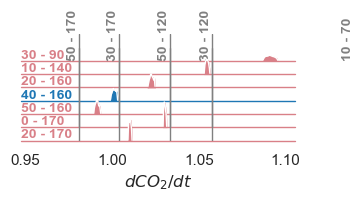

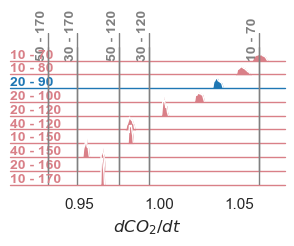

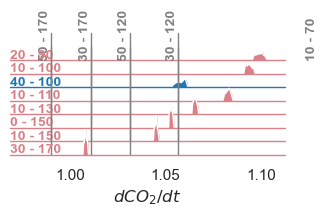

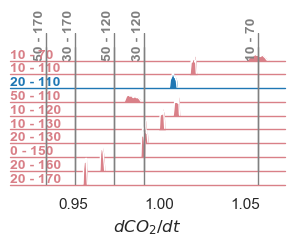

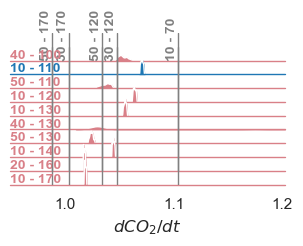

In [61]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & 
                                               (expected_ds['curvature'] == curve), drop=True).time.values
        
        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                print()
                # fig, ax = plt.subplots(2, 3, figsize=(8, 4))
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                
                #### Pareto analysis ####
                pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection))
                Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()                
                pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                       y=flatNorm_logprob, 
                                                                       maximize_x=False, maximize_y=False) 
                best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                         metric_x=Norm_uncertaintyRange,
                                                                         metric_y=Norm_logprob)
                coords_pareto_uncertaintyRange_logprob = pa.get_coords_pareto(pareto_indices=pareto_uncertaintyRange_logprob)
                argmin_distance_pareto_uncertaintyRange_logprob = pa.argmin_distance
                #########################
                print('Deadband:', deadband_coords[best_pareto_y].values)
                print('Cutoff:', cutoff_coords[best_pareto_x].values)

                hist_dcdt = dsMC.sel(time=time_selection,
                                    deadband=deadband_coords[best_pareto_y].values,
                                    cutoff=cutoff_coords[best_pareto_x].values, 
                                    )['dcdt(HM)']
                # print(hist_dcdt)
                hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)

                # Arbitrary deadband and cutoff
                arbitrary_results = {'deadband':[10,30, 30,50,50],
                                     'cutoff':[70,120,170,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
                
                for deadband, cutoff in zip(arbitrary_results['deadband'], arbitrary_results['cutoff']):
                    dcdt_arb = ds.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)
                    arbitrary_results['dcdt(HM)'].append(dcdt_arb['dcdt(HM)'].values)
                    arbitrary_results['R2'].append(dcdt_arb['R2(HM)'].values)

                ############################

                                
                hist_dcdt_pareto = dsMC.sel(time=time_selection,
                                            cutoff=cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]], 
                                            deadband=deadband_coords[coords_pareto_uncertaintyRange_logprob[1]])['dcdt(HM)']
                print('Cutff - Deadband:')
                print(cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values)
                print(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values)


                df_pareto = pd.DataFrame()
                for deadband, cutoff in zip(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values,
                                            cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values):
                    hist_dcdt = dsMC.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)['dcdt(HM)']
                    hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                    hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)

                    df_pareto = pd.concat([df_pareto, hist_dcdt.to_dataframe().reset_index()], ignore_index=True)
                
                df_pareto['deadband-cutoff'] = df_pareto['deadband'].astype(str) + ' - ' + df_pareto['cutoff'].astype(str)
                # print(df_pareto)

                colors = ['#d98088' for _ in range(len(np.unique(df_pareto['deadband-cutoff'])))]
                colors = []
# # print(df_pareto)
                for c in range(len(np.unique(df_pareto['deadband-cutoff']))):
                    if c == argmin_distance_pareto_uncertaintyRange_logprob:
                        colors.append('#1f77b4')
                    else:
                        colors.append('#d98088')
                    

                pal = sns.color_palette(colors)


                g = sns.FacetGrid(data=df_pareto, 
                                  row='deadband-cutoff', hue='deadband-cutoff',
                                  aspect=18, height=0.5*cm, palette=pal)

                g.map(sns.kdeplot, 'dcdt(HM)', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=0.5)
                g.map(sns.kdeplot, 'dcdt(HM)', clip_on=False, color='w', lw=1, bw_adjust=1)
                g.refline(y=0, linewidth=1,linestyle='-', color=None, clip_on=False)
                # g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
                def label2(x, color, label):
                    ax = plt.gca()
                    ax.text(0, .2, label, fontweight="bold", color=color, fontsize=10,
                            ha="left", va="center", transform=ax.transAxes)
                def add_text_first_row_only(x, **kwargs):
                    global row_counter
                    ax = plt.gca()
                    if row_counter == 0:
                        for i, a in enumerate(zip(arbitrary_results['dcdt(HM)'], arbitrary_results['deadband'], arbitrary_results['cutoff'])): 
                            if a[0] == np.nan:
                                continue
                            ax.text(a[0], 0.2, f"{a[1]} - {a[2]}", color='grey', ha='right', va='bottom', 
                                    rotation=90, fontsize=10,
                                    fontweight='bold'
                                    )
                    row_counter += 1

                # g.map(plt.axvline, x=1, color='black', linestyle='-', linewidth=1)
                print('Arbitrary results:')
                print(arbitrary_results['dcdt(HM)'])
                for a in arbitrary_results['dcdt(HM)']:
                    # print(a)
                    g.map(plt.axvline, x=a, color='grey', linestyle='-', linewidth=1)
                        # g.map(plt.text, x=a, y=0.2, s=f'{a:.2f}', color='black', ha='left', va='center')
                print()
                row_counter = 0
                g.map(add_text_first_row_only, 'dcdt(HM)')

                g.map(label2, 'dcdt(HM)')


                g.fig.subplots_adjust(hspace=-.5)
                # g.subplots_adjust(hspace=-.5)
                g.set_titles("")
                g.set(yticks=[], ylabel="")
                g.despine(bottom=True, left=True)
                # g.set(xlim=(0.9,1.15))
                xrange = (df_pareto['dcdt(HM)'].max() - df_pareto['dcdt(HM)'].min())*0.4
                g.set(xlim=(df_pareto['dcdt(HM)'].min()-xrange, df_pareto['dcdt(HM)'].max()+xrange/4))

                g.set(xlabel='$dCO_2/dt$')
                


                # break
            except Exception as e:
                # print('Error in plotting')
                print(e)
                continue


Deadband: 40
Cutoff: 160
Cutff - Deadband:
[ 90 140 160 160 160 170 170]
[30 10 20 40 50  0 20]
Arbitrary results:
[array(1.1392625), array(1.05786063), array(1.00415718), array(1.03362956), array(0.98134517)]
list index out of range

Deadband: 40
Cutoff: 160
Cutff - Deadband:
[ 90 140 160 160 160 170 170]
[30 10 20 40 50  0 20]
Arbitrary results:
[array(1.1392625), array(1.05786063), array(1.00415718), array(1.03362956), array(0.98134517)]
list index out of range

Deadband: 20
Cutoff: 90
Cutff - Deadband:
[ 70  80  90 100 120 120 150 150 160 170]
[10 10 20 20 20 40 10 40 20 10]
Arbitrary results:
[array(1.06232931), array(0.99353409), array(0.94890984), array(0.97484355), array(0.9305119)]
list index out of range

Deadband: 20
Cutoff: 90
Cutff - Deadband:
[ 70  80  90 100 120 120 150 150 160 170]
[10 10 20 20 20 40 10 40 20 10]
Arbitrary results:
[array(1.06232931), array(0.99353409), array(0.94890984), array(0.97484355), array(0.9305119)]
list index out of range

Deadband: 40
Cutoff

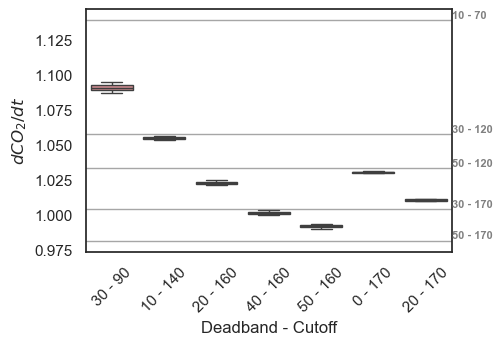

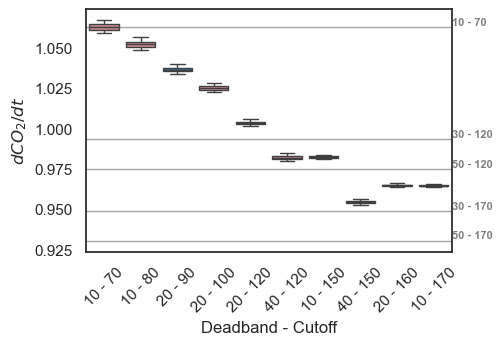

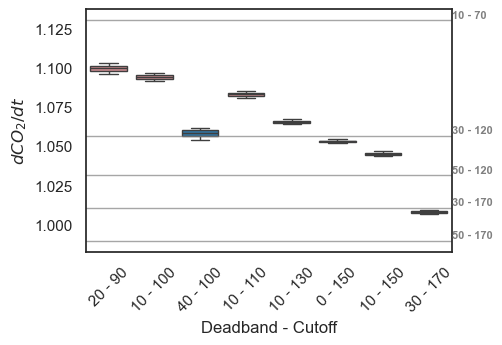

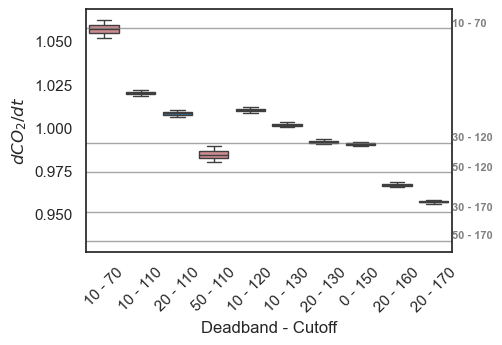

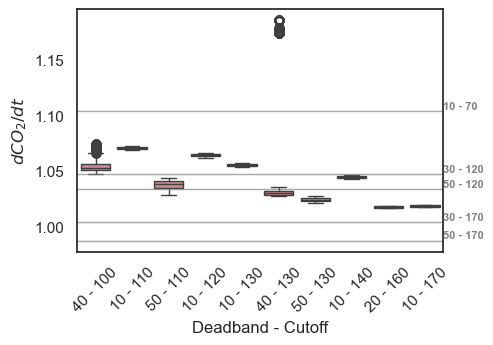

In [62]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & 
                                               (expected_ds['curvature'] == curve), drop=True).time.values
        
        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                print()
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                
                #### Pareto analysis ####
                pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection))
                Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()                
                pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                       y=flatNorm_logprob, 
                                                                       maximize_x=False, maximize_y=False) 
                best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                         metric_x=Norm_uncertaintyRange,
                                                                         metric_y=Norm_logprob)
                coords_pareto_uncertaintyRange_logprob = pa.get_coords_pareto(pareto_indices=pareto_uncertaintyRange_logprob)
                argmin_distance_pareto_uncertaintyRange_logprob = pa.argmin_distance
                #########################
                print('Deadband:', deadband_coords[best_pareto_y].values)
                print('Cutoff:', cutoff_coords[best_pareto_x].values)

                hist_dcdt = dsMC.sel(time=time_selection,
                                    deadband=deadband_coords[best_pareto_y].values,
                                    cutoff=cutoff_coords[best_pareto_x].values, 
                                    )['dcdt(HM)']
                hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)

                # Arbitrary deadband and cutoff
                arbitrary_results = {'deadband':[10,30, 30,50,50],
                                     'cutoff':[70,120,170,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
                
                for deadband, cutoff in zip(arbitrary_results['deadband'], arbitrary_results['cutoff']):
                    dcdt_arb = ds.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)
                    arbitrary_results['dcdt(HM)'].append(dcdt_arb['dcdt(HM)'].values)
                    arbitrary_results['R2'].append(dcdt_arb['R2(HM)'].values)

                ############################
                                
                hist_dcdt_pareto = dsMC.sel(time=time_selection,
                                            cutoff=cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]], 
                                            deadband=deadband_coords[coords_pareto_uncertaintyRange_logprob[1]])['dcdt(HM)']
                print('Cutff - Deadband:')
                print(cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values)
                print(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values)

                df_pareto = pd.DataFrame()
                for deadband, cutoff in zip(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values,
                                            cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values):
                    hist_dcdt = dsMC.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)['dcdt(HM)']
                    hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                    hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)

                    df_pareto = pd.concat([df_pareto, hist_dcdt.to_dataframe().reset_index()], ignore_index=True)
                
                df_pareto['deadband-cutoff'] = df_pareto['deadband'].astype(str) + ' - ' + df_pareto['cutoff'].astype(str)

                # Create color mapping for best pareto solution
                unique_combinations = df_pareto['deadband-cutoff'].unique()
                colors = []
                for c in range(len(unique_combinations)):
                    if c == argmin_distance_pareto_uncertaintyRange_logprob:
                        colors.append('#1f77b4')  # Blue for best pareto solution
                    else:
                        colors.append('#d98088')  # Pink for other solutions
                    
                # Create the boxplot
                fig, ax = plt.subplots(figsize=(12*cm, 8*cm))
                
                # Create boxplot
                box_plot = sns.boxplot(data=df_pareto, 
                                      x='deadband-cutoff', 
                                      y='dcdt(HM)', 
                                      palette=colors,
                                      ax=ax)
                
                # Add horizontal lines for arbitrary results  
                print('Arbitrary results:')
                print(arbitrary_results['dcdt(HM)'])
                for i, a in enumerate(arbitrary_results['dcdt(HM)']):
                    if not np.isnan(a):
                        ax.axhline(y=a, color='grey', linestyle='-', linewidth=1, alpha=0.7)
                        # Add text label for arbitrary results
                        ax.text(len(unique_combinations)-0.5, a, 
                               f"{arbitrary_results['deadband'][i]} - {arbitrary_results['cutoff'][i]}", 
                               color='grey', ha='left', va='bottom', fontsize=8, fontweight='bold')
                
                # Customize the plot
                ax.set_xlabel('Deadband - Cutoff')
                ax.set_ylabel('$dCO_2/dt$')
                ax.tick_params(axis='x', rotation=45)
                
                # Highlight the best pareto solution
                best_combo = unique_combinations[argmin_distance_pareto_uncertaintyRange_logprob]
                for i, combo in enumerate(unique_combinations):
                    if combo == best_combo:
                        # Add a border or different styling to highlight best solution
                        box_plot.artists[i].set_edgecolor('black')
                        box_plot.artists[i].set_linewidth(2)
                
                plt.tight_layout()
                plt.show()
                print()

            except Exception as e:
                print(e)
                continue